# Project: Mobile Manipulator Planning
**Course:** Roboterprogrammierung (Winter 25/26)  
**Institution:** Hochschule Karlsruhe - University of Applied Sciences (HKA)  

## 🎯 Objective
This notebook implements and evaluates a **Collision Checker** for a planar mobile robot consisting of a movable base and a 2-DOF rotatory arm. The goal is to benchmark path planning algorithms (LazyPRM, VisibilityPRM, etc.) in various environments while handling self-collisions and obstacle avoidance.

## ⚙️ Key Features
* **Mobile Base:** Free-form shape definition (2D).
* **Manipulator:** Configurable arm segments (Length, Thickness, Joint Limits).
* **Collision Detection:** Custom implementation handling Base-Obstacle, Arm-Obstacle, and Self-Collision (Arm-Base).

## Imports & Autoreload


In [1]:
# --- Auto-reload modules when source code changes ---
# This is crucial so you don't have to restart the kernel when editing src/ files
%load_ext autoreload
%autoreload 2

# --- Standard Imports ---
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from ipywidgets import interact, FloatSlider, Dropdown
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# --- Add 'src' directory to path to import modules ---
# Assuming this notebook is in the 'notebooks/' folder and source is in 'src/'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
# IMPORTANT: To ensure that IPLazyPRM finds its dependencies (IPPerfMonitor),
# we explicitly add the src/planners folder to the path.
planners_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src', 'planners'))
if planners_path not in sys.path:
    sys.path.append(planners_path)

print(f"Project Root added to path: {project_root}")

# --- Import Collision Checker ---
from src.collision_checker import CollisionChecker

# --- Import Test Suite ---
from src.IPTestSuite import *

# --- Import Planners ---
from src.planners.IPPerfMonitor import IPPerfMonitor
import src.planners.IPBasicPRM
import src.planners.IPVISBasicPRM

import src.planners.IPVisibilityPRM
import src.planners.IPVISVisibilityPRM

import src.planners.IPLazyPRM
from src.planners.IPVISLazyPRM import lazyPRMVisualize

Project Root added to path: /Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator


## Creating Planner Factory

In [2]:
plannerFactory = dict()

visbilityConfig = dict()
visbilityConfig["ntry"] = 300
plannerFactory["visibilityPRM"] = [src.planners.IPVisibilityPRM.VisPRM, visbilityConfig, src.planners.IPVISVisibilityPRM.visibilityPRMVisualize]

lazyConfig = dict()
lazyConfig["initialRoadmapSize"] = 100
lazyConfig["updateRoadmapSize"]  = 50
lazyConfig["kNearest"] = 16
lazyConfig["maxIterations"] = 200
plannerFactory["lazyPRM"] = [src.planners.IPLazyPRM.LazyPRM, lazyConfig, src.planners.IPVISLazyPRM.lazyPRMVisualize]

print("Planner initialization successfull. Following Planners loaded:")
plannerNames = []
for planner in plannerFactory:
    plannerNames.append(planner)
    print(f"    {planner}")

Planner initialization successfull. Following Planners loaded:
    visibilityPRM
    lazyPRM


## Import & Initialisation

In [3]:
# Initialize the Collision Checker instance
# We use the constants defined in the Configuration cell above
cc = CollisionChecker(ROBOT_BASE_SHAPE, ROBOT_ARM_CONFIG, ARM_OFFSET)

print("Collision checker initialization successfull. Following TestSuits loaded:")
benchNames = []
for benchmark in benchList:
    benchNames.append(benchmark.name)
    print(f"    {benchmark.name}")

Collision checker initialization successfull. Following TestSuits loaded:
    Empty World
    The Wall
    Narrow Passage
    Forest
    Shelf Reach


## Interactive Visualization

In [7]:
# --- Setup ---
# Namen für das Dropdown-Menü extrahieren
bench_names = [b.name for b in benchList]

def interact_bench_suite(bench_name, x, y, theta, q1, q2, check_self):
    """
    Interaktive Steuerung des Roboters in einer ausgewählten Benchmark-Umgebung.
    """
    plt.close('all')

    # 1. Den passenden Benchmark und CollisionChecker auswählen
    # Wir suchen das Benchmark-Objekt anhand des Namens
    current_bench = next(b for b in benchList if b.name == bench_name)
    cc = current_bench.collisionChecker

    # 2. Self-Collision Flag setzen
    try:
        cc.toggle_self_collision(check_self)
    except AttributeError:
        pass

    # 3. Konfiguration erstellen (Numpy Array!)
    config = np.array([x, y, theta, q1, q2], dtype=float)

    # 4. Kollision prüfen
    try:
        if hasattr(cc, 'pointInCollision'):
            is_collision = cc.pointInCollision(config)
        else:
            is_collision = cc.is_in_collision(config)
    except Exception as e:
        print(f"Fehler Collision Check: {e}")
        is_collision = True

    # 5. Zeichnen
    try:
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # --- A. Hindernisse und aktueller Roboter ---
        cc.draw(config, ax)
        
        # --- B. Start und Ziel des Benchmarks einblenden (Hilfreich!) ---
        # Startkonfiguration (Grün gestrichelt)
        start_conf = np.array(current_bench.startList[0])
        geo_start = cc.get_robot_geometry(start_conf)
        ax.plot(*geo_start['base'].exterior.xy, color='green', linestyle='--', alpha=0.5, label='Start Base')
        
        # Zielkonfiguration (Rot gestrichelt)
        goal_conf = np.array(current_bench.goalList[0])
        geo_goal = cc.get_robot_geometry(goal_conf)
        ax.plot(*geo_goal['base'].exterior.xy, color='red', linestyle='--', alpha=0.5, label='Goal Base')
        
        # Arme für Start/Ziel auch andeuten (optional, hier nur Basis der Übersicht halber)
        
        # --- C. Plot Settings ---
        ax.set_xlim(LIMITS)
        ax.set_ylim(LIMITS) # Y-Achse ist meist schmaler bei diesen Benchmarks
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_aspect('equal')
        ax.legend(loc='upper right')

        # Titel & Status
        status_color = 'red' if is_collision else 'green'
        status_text = "COLLISION!" if is_collision else "FREE"
        ax.set_title(f"Benchmark: {bench_name}\nStatus: {status_text}", 
                     color=status_color, fontweight='bold', fontsize=14)
        
        plt.show()
        
    except Exception as e:
        print(f"Fehler beim Zeichnen: {e}")

# --- Widgets erstellen ---
interact(interact_bench_suite, 
         bench_name=Dropdown(options=bench_names, description='Scenario'),
         x=FloatSlider(min=LIMITS[0], max=LIMITS[1], step=0.1, value=0),
         y=FloatSlider(min=LIMITS[0], max=LIMITS[1], step=0.1, value=0),
         theta=FloatSlider(min=-3.14, max=3.14, step=0.1, value=0, description='Base Theta'),
         # Die Limits für die Gelenke holen wir direkt aus der zentralen Config
         q1=FloatSlider(min=ROBOT_ARM_CONFIG[0][2][0], max=ROBOT_ARM_CONFIG[0][2][1], step=0.1, value=0, description='Joint 1'),
         q2=FloatSlider(min=ROBOT_ARM_CONFIG[1][2][0], max=ROBOT_ARM_CONFIG[1][2][1], step=0.1, value=0, description='Joint 2'),
         check_self=True
        );

interactive(children=(Dropdown(description='Scenario', options=('Empty World', 'The Wall', 'Narrow Passage', '…

## Planning

In [5]:
resultList = list()
plotList = []

from src.planners.IPResultCollection import ResultCollection

for key,producer in list(plannerFactory.items()):
    print("="*50)
    print(f"{key}:")
    for benchmark in benchList:
        print(f"    Running Benchmark {benchmark.name} - {benchmark.description}")
        planner = producer[0](benchmark.collisionChecker)
        IPPerfMonitor.clearData()
        try:
            resultList.append(ResultCollection(
                key,
                planner,
                benchmark,
                planner.planPath(
                    benchmark.startList,benchmark.goalList,producer[1]
                    ),
                    IPPerfMonitor.dataFrame()
            ),
            )
            plotList.append(1)
        except Exception as e:
        #    throw e
            plotList.append(0)
            print("    PLANNING ERROR ! PLANNING ERROR ! PLANNING ERROR ", e)
            pass

print("="*50)
# print(plotList)

visibilityPRM:
    Running Benchmark Empty World - Freier Raum. Testet, ob der Planer eine direkte Linie findet.
    Running Benchmark The Wall - Eine Wand mit einer Lücke. Der Roboter muss durchfahren.
    Running Benchmark Narrow Passage - Narrow Passage. Erfordert präzise Basis-Bewegung.
    Running Benchmark Forest - Clutter. Roboter muss slalomen, Arm darf nicht ausschlagen.
    Running Benchmark Shelf Reach - Reach Task. Die Basis kann das Ziel nicht erreichen, der Arm muss rüberreichen.
lazyPRM:
    Running Benchmark Empty World - Freier Raum. Testet, ob der Planer eine direkte Linie findet.
    Running Benchmark The Wall - Eine Wand mit einer Lücke. Der Roboter muss durchfahren.
    Running Benchmark Narrow Passage - Narrow Passage. Erfordert präzise Basis-Bewegung.
    Running Benchmark Forest - Clutter. Roboter muss slalomen, Arm darf nicht ausschlagen.
    Running Benchmark Shelf Reach - Reach Task. Die Basis kann das Ziel nicht erreichen, der Arm muss rüberreichen.


## Visualization

visibilityPRM - Empty World | 0, 0
    PLANNED --> plotting
visibilityPRM - The Wall | 1, 0
    PLANNED --> plotting
visibilityPRM - Narrow Passage | 2, 0
    PLANNED --> plotting
visibilityPRM - Forest | 3, 0
    PLANNED --> plotting
visibilityPRM - Shelf Reach | 4, 0
    PLANNED --> plotting
lazyPRM - Empty World | 0, 1
    PLANNED --> plotting
lazyPRM - The Wall | 1, 1
    PLANNED --> plotting
lazyPRM - Narrow Passage | 2, 1
    PLANNED --> plotting
lazyPRM - Forest | 3, 1
    PLANNED --> plotting
lazyPRM - Shelf Reach | 4, 1
    PLANNED --> plotting


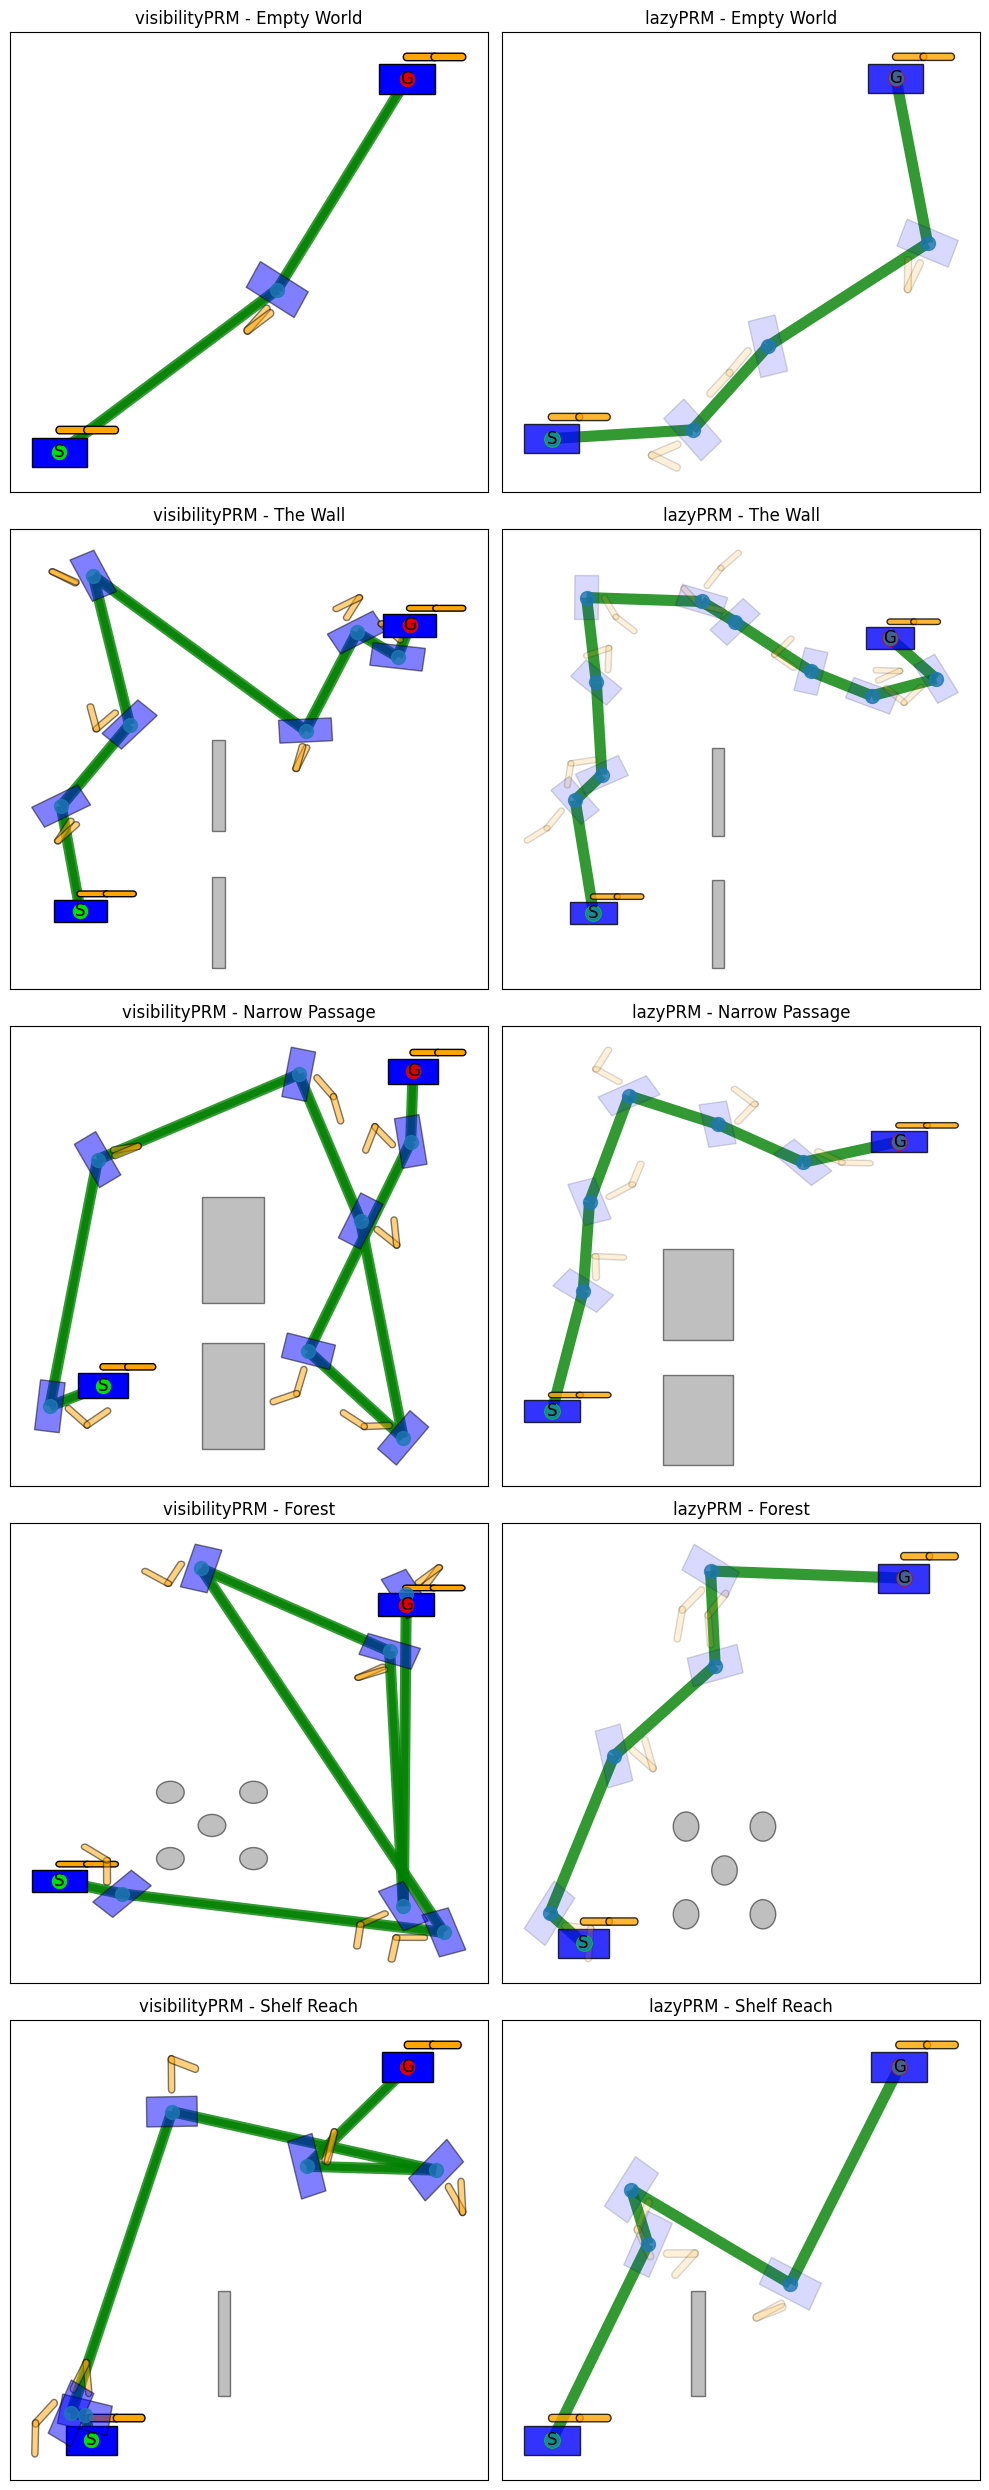

In [6]:
fig, axes = plt.subplots(len(benchList), len(plannerFactory), figsize=(10, len(benchList)*5), squeeze=False)
resultList_iter = iter(resultList)

for i, _ in enumerate(plotList):
    row_idx = i % len(benchList)
    col_idx = i // len(benchList)

    ax = axes[row_idx, col_idx]

    title = plannerNames[col_idx] + " - " + benchNames[row_idx]
    print("="*50)
    print(f"{title} | {row_idx}, {col_idx}")

    if plotList[i]==0:
        print("    ERROR --> next one")
        title += " (ERROR!)"
        ax.set_title(title)
        continue
    else:
        print("    PLANNED --> plotting")

    # print(f"result.solution: {result.solution}")

    # for node, data in planner.graph.nodes(data=True):
    #     if 'pos' in data:
    #         original_graph_pos[node] = data['pos']
    #         # WICHTIG: IPVIS braucht (x,y), also die ersten 2 Werte
    #         planner.graph.nodes[node]['pos'] = data['pos'][0:2] 

    result = next(resultList_iter)
    # print(f"    {result.solution}")
    # print(f"    {result.solution==[]}")

    if result.solution == []:
        title += " (No path found!)"
    ax.set_title(title)

    try:
        #IPVISBasicsPRM.basicPRMVisualize(result.planner, result.solution, ax=ax, nodeSize=100))
        plannerFactory[result.plannerFactoryName][2](result.planner, result.solution, ax=ax, nodeSize=100)
    except Exception as e:
        print ("Error", e)
        pass

plt.tight_layout()
print("="*50)
    